In [3]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

In [4]:
def calculate_metrics_from_confusion_matrix(conf_matrix):
    """
    Calculate F1 score and accuracy from a confusion matrix.

    Parameters:
    - conf_matrix: pandas DataFrame
        A confusion matrix where rows represent true labels and columns represent predicted labels.

    Returns:
    - dict: A dictionary containing 'F1 Score' and 'Accuracy'.
    """
    # Extract confusion matrix values
    TP = conf_matrix.iloc[1, 1]  # True Positives
    FP = conf_matrix.iloc[:, 1].sum() - TP  # False Positives
    FN = conf_matrix.iloc[1, :].sum() - TP  # False Negatives
    TN = conf_matrix.iloc[0, 0]  # True Negatives

    # Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Accuracy
    total = conf_matrix.values.sum()
    accuracy = (TP + TN) / total if total > 0 else 0

    return {"F1 Score": f1_score, "Accuracy": accuracy}

In [5]:
def calculate_pearson_r(df1, df2, cell_type_key='cell_type_key', batch_key='batch_all_with_condition'):
    """
    Calculate the Pearson r for the same cell_type_key and batch_all_with_condition
    across two dataframes, sorted by keys.
    
    Parameters:
        df1 (pd.DataFrame): First dataframe with cell type, batch, and gene columns.
        df2 (pd.DataFrame): Second dataframe with the same structure as df1.
        cell_type_key (str): Column name for cell type key.
        batch_key (str): Column name for batch key.
    
    Returns:
        OrderedDict: A sorted dictionary where keys are tuples of (cell_type_key, batch_key)
                     and values are the Pearson r.
    """
    # Initialize a dictionary to store results
    results = {}
    
    # Find common keys based on cell_type_key and batch_all_with_condition
    common_keys = pd.merge(
        df1[[cell_type_key, batch_key]].drop_duplicates(),
        df2[[cell_type_key, batch_key]].drop_duplicates(),
        on=[cell_type_key, batch_key]
    )
    
    # Iterate over each common key
    for _, row in common_keys.iterrows():
        cell_type = row[cell_type_key]
        batch = row[batch_key]
        
        # Filter rows matching the cell_type_key and batch_key
        sub_df1 = df1[(df1[cell_type_key] == cell_type) & (df1[batch_key] == batch)]
        sub_df2 = df2[(df2[cell_type_key] == cell_type) & (df2[batch_key] == batch)]
        
        # Align columns (gene names)
        common_genes = sub_df1.columns.intersection(sub_df2.columns).difference([cell_type_key, batch_key])
        values1 = sub_df1[common_genes].values.flatten()
        values2 = sub_df2[common_genes].values.flatten()
        
        # Exclude genes with p-values of 0 or 1 in either dataframe
        valid_mask = (values1 > 0) & (values1 < 1) & (values2 > 0) & (values2 < 1)
        valid_values1 = values1[valid_mask]
        valid_values2 = values2[valid_mask]
        
        # If no valid values remain, skip this key
        if len(valid_values1) <=50 or len(valid_values2) <=50:
            #results[(cell_type, batch)] = np.nan
            continue
        
        # Calculate logit transformation
        logit1 = np.log(valid_values1 / (1 - valid_values1))
        logit2 = np.log(valid_values2 / (1 - valid_values2))
        
        # Calculate Pearson r
        r, _ = pearsonr(logit1, logit2)
        results[(cell_type, batch)] = r
    
    # Sort the results by keys and return as OrderedDict
    sorted_results = OrderedDict(sorted(results.items(), key=lambda x: x[0]))
    return sorted_results

In [6]:
def mark_pvalues_and_plot_confusion(df1, df2, cell_type_key='cell_type_key', batch_key='batch_all_with_condition', cutoff=0.05):
    """
    Mark p-values as True (below cutoff) or False (above cutoff) and plot the normalized confusion matrix.

    Parameters:
        df1 (pd.DataFrame): First dataframe with true p-values.
        df2 (pd.DataFrame): Second dataframe with predicted p-values.
        cell_type_key (str): Column name for cell type key.
        batch_key (str): Column name for batch key.
        cutoff (float): Threshold for marking p-values as significant.
    """
    # Initialize a dictionary to store results
    results = []

    # Find common keys based on cell_type_key and batch_key
    common_keys = pd.merge(
        df1[[cell_type_key, batch_key]].drop_duplicates(),
        df2[[cell_type_key, batch_key]].drop_duplicates(),
        on=[cell_type_key, batch_key]
    )

    # Iterate over each common key
    for _, row in common_keys.iterrows():
        cell_type = row[cell_type_key]
        batch = row[batch_key]

        # Filter rows matching the cell_type_key and batch_key
        sub_df1 = df1[(df1[cell_type_key] == cell_type) & (df1[batch_key] == batch)]
        sub_df2 = df2[(df2[cell_type_key] == cell_type) & (df2[batch_key] == batch)]

        # Align columns (gene names)
        common_genes = sub_df1.columns.intersection(sub_df2.columns).difference([cell_type_key, batch_key])
        values1 = sub_df1[common_genes].values.flatten()
        values2 = sub_df2[common_genes].values.flatten()

        # Mark p-values based on the cutoff
        true_labels = values1 < cutoff
        predicted_labels = values2 < cutoff

        # Append results
        results.extend(zip(true_labels, predicted_labels))

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results, columns=['True', 'Predicted'])
    print(results_df)
    
    # Create confusion matrix
    confusion_matrix = pd.crosstab(results_df['True'], results_df['Predicted'], rownames=['True'], colnames=['Predicted'])

    metrics=calculate_metrics_from_confusion_matrix(confusion_matrix)
    print("Accuracy and F1 score",metrics)
    
    normalized_matrix = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)

    # Plot the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, annot_kws={"size": 36})
    #plt.title("Normalized Confusion Matrix", fontsize=20)
    plt.xlabel("Denoised", fontsize=34)
    plt.ylabel("Raw", fontsize=34)
    plt.xticks(fontsize=34)
    plt.yticks(fontsize=34)
    plt.tight_layout()
    plt.show()

In [7]:
def paired_comparison_box_violin_plot(ordered_dicts, method_names):
    """
    Create a paired comparison between methods and visualize results with a combined
    boxplot, violin plot, and scatter plot of individual values. Annotate the mean and median values for each method.

    Parameters:
        ordered_dicts (list of OrderedDict): List of OrderedDicts with (cell_type, batch) keys and correlation values.
        method_names (list of str): Names corresponding to each OrderedDict.
    """
    # Check that the input lists are of the same length
    assert len(ordered_dicts) == len(method_names), "The number of OrderedDicts and method names must match."

    # Convert OrderedDicts to a DataFrame for easier manipulation
    data = []
    for method_name, odict in zip(method_names, ordered_dicts):
        for key, value in odict.items():
            cell_type, batch = key
            data.append((cell_type, batch, method_name, value))

    df = pd.DataFrame(data, columns=['CellType', 'Batch', 'Method', 'Correlation'])

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Define a color palette based on the method names
    palette = sns.color_palette("husl", len(method_names))

    # Combined boxplot and violin plot
    sns.violinplot(x='Method', y='Correlation', data=df, inner=None, palette=palette)
    sns.boxplot(x='Method', y='Correlation', data=df, width=0.2, showcaps=True, showfliers=False,
                whiskerprops={'linewidth': 2}, boxprops={'facecolor': 'white', 'edgecolor': 'black'},
                medianprops={'color': 'black', 'linewidth': 2})

    # Add scatter points for individual values
    for i, method in enumerate(method_names):
        method_data = df[df['Method'] == method]['Correlation']
        x_coords = np.random.normal(i, 0.04, size=len(method_data))  # Add jitter for scatter points
        plt.scatter(x_coords, method_data, alpha=0.7, color=palette[i], edgecolor="k", s=50, label=f"{method} Values")

    # Annotate mean and median values
    for i, method in enumerate(method_names):
        method_data = df[df['Method'] == method]['Correlation']
        mean_val = method_data.mean()
        median_val = method_data.median()
        plt.text(i, mean_val + 0.05, f"Mean: {mean_val:.2f}", ha='center', va='bottom', fontsize=14, color='blue', weight='bold')
        plt.text(i, median_val - 0.05, f"Median: {median_val:.2f}", ha='center', va='top', fontsize=14, color='red', weight='bold')

    # Customize plot
    #plt.title("Paired Comparison of Methods with Mean, Median, and Individual Values", fontsize=20)
    plt.ylabel("Pearson Correlation (r)", fontsize=18)
    plt.xlabel("Method", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.tight_layout()
    plt.show()

# ECCITE dataset

        True  Predicted
0       True       True
1      False      False
2       True       True
3      False       True
4      False      False
...      ...        ...
36013  False      False
36014  False      False
36015   True       True
36016  False      False
36017  False      False

[36018 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.7265399488045313, 'Accuracy': 0.8605974790382587}


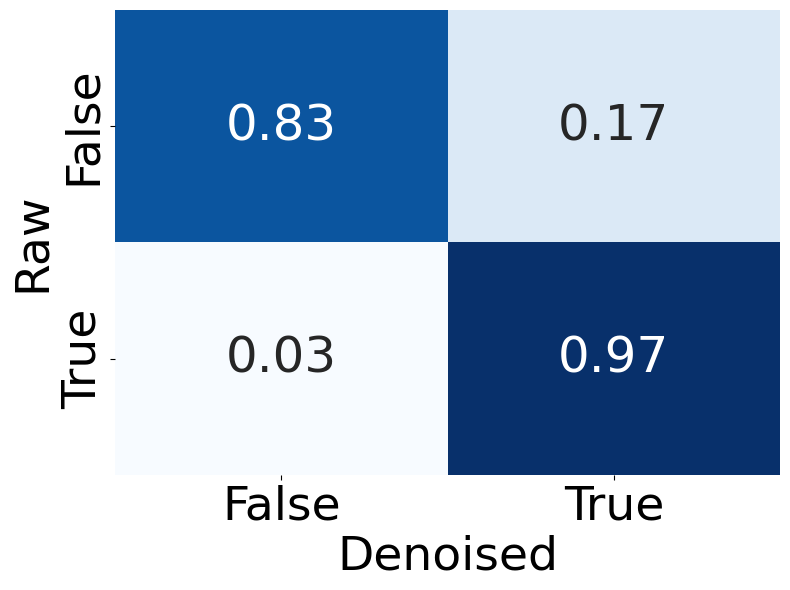

In [6]:
df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/reproducible/evaluate/ECCITE_perturbation_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/reproducible/evaluate/ECCITE_perturbation_denoised_DE.csv")
results_ndreamer=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

        True  Predicted
0       True       True
1      False      False
2       True       True
3      False       True
4      False      False
...      ...        ...
36013  False      False
36014  False      False
36015   True       True
36016  False      False
36017  False      False

[36018 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.5028379387602688, 'Accuracy': 0.630351490921206}


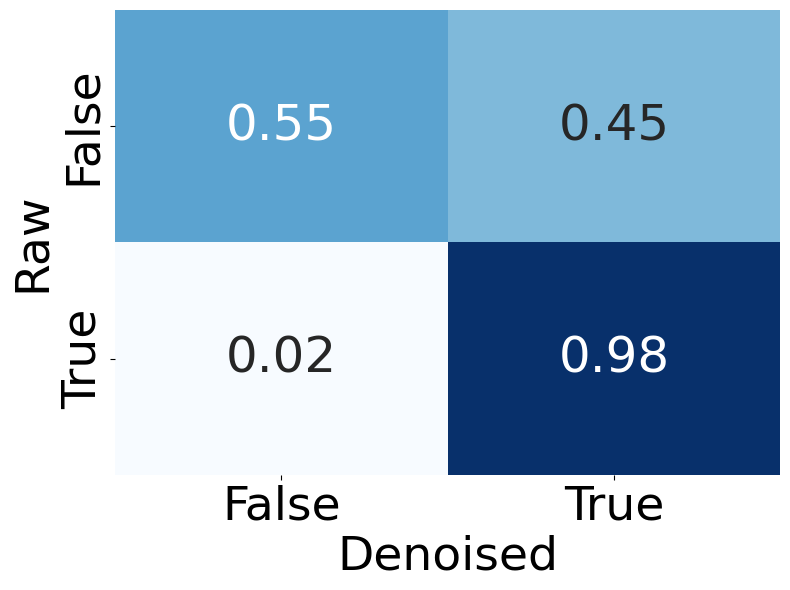

In [7]:
df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/cellanova/ECCITE_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/cellanova/ECCITE_denoised_DE.csv")
results_cellanova=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

        True  Predicted
0       True       True
1      False       True
2       True       True
3      False       True
4      False       True
...      ...        ...
36013  False       True
36014  False      False
36015   True       True
36016  False      False
36017  False       True

[36018 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.3748338502436863, 'Accuracy': 0.3732022877450164}


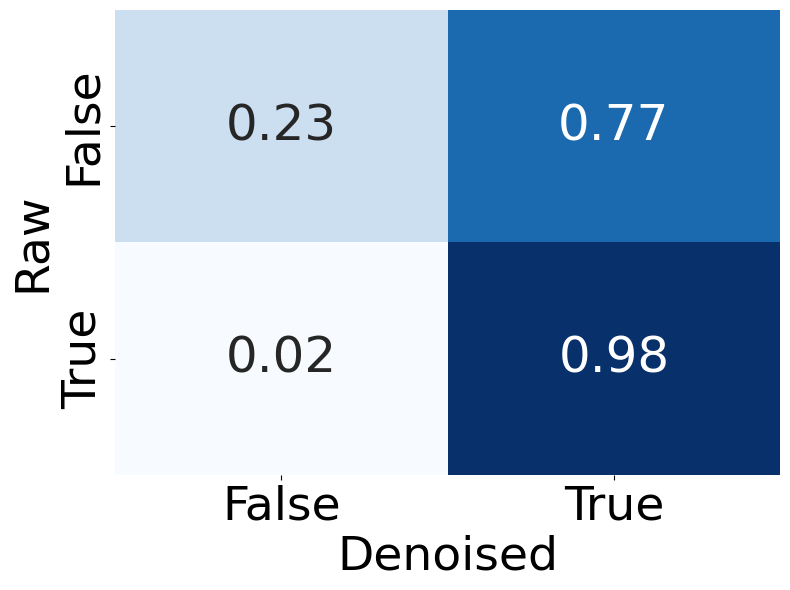

In [8]:
df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/scd/ECCITE_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/scd/ECCITE_denoised_DE.csv")
results_scd=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

/tmp/ipykernel_1204373/3160381379.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Method', y='Correlation', data=df, inner=None, palette=palette)


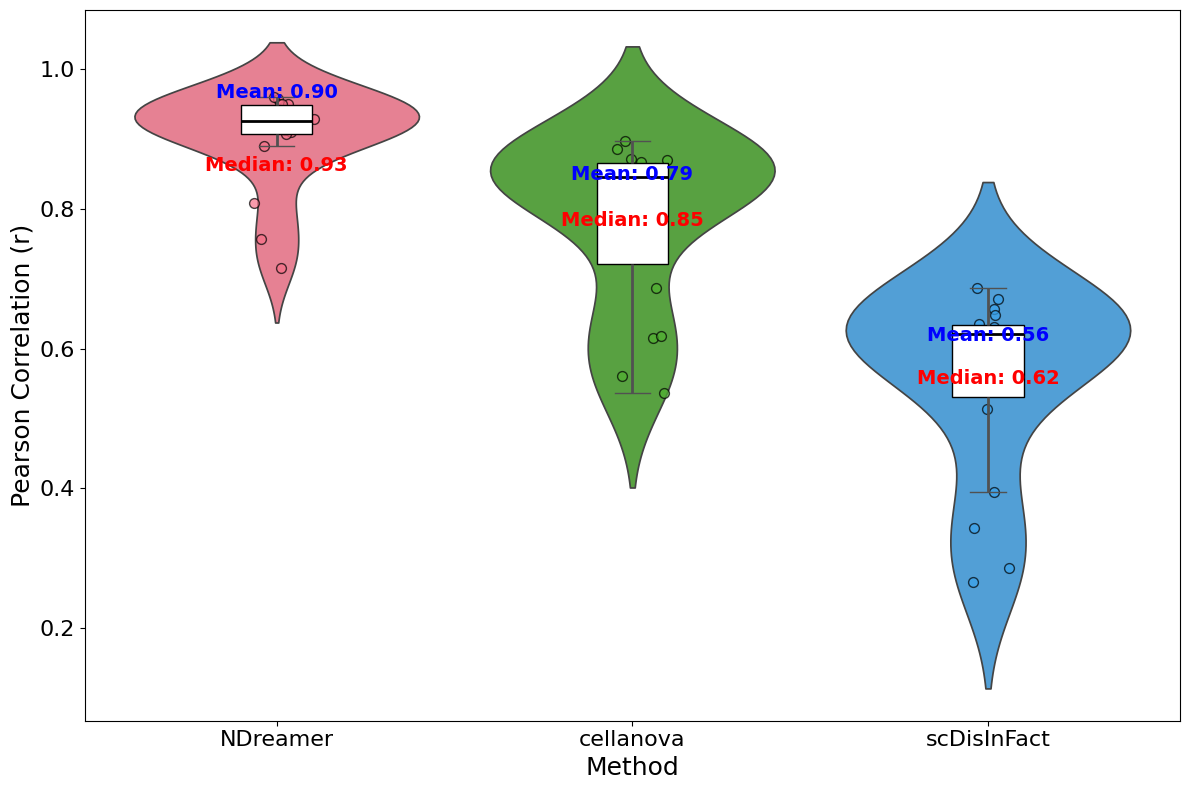

In [9]:
paired_comparison_box_violin_plot([results_ndreamer,results_cellanova,results_scd], ["NDreamer","cellanova", "scDisInFact"])

# ASD dataset

ASD1

         True  Predicted
0        True       True
1       False       True
2       False      False
3       False      False
4       False       True
...       ...        ...
328159  False      False
328160  False      False
328161  False      False
328162  False      False
328163  False      False

[328164 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.5819598177937196, 'Accuracy': 0.768445045769798}


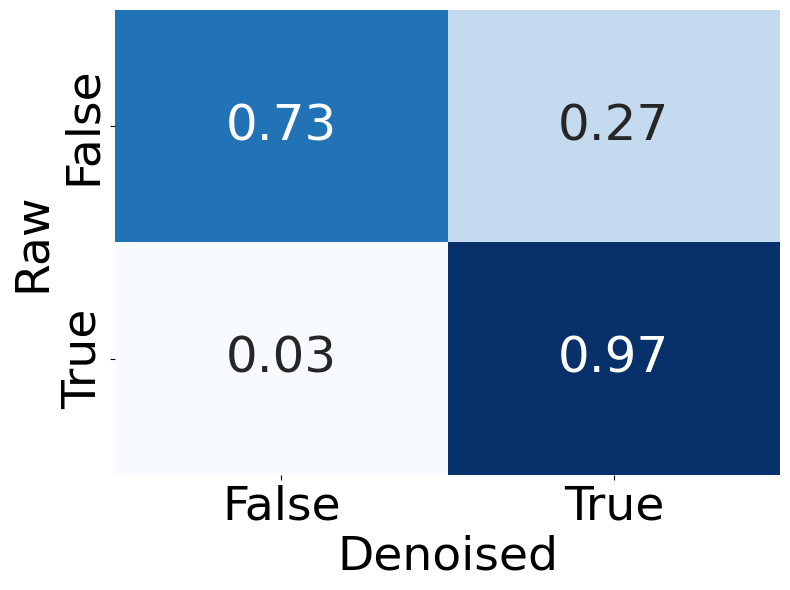

         True  Predicted
0        True       True
1       False       True
2       False      False
3       False       True
4       False       True
...       ...        ...
328159  False       True
328160  False      False
328161  False       True
328162  False      False
328163  False       True

[328164 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.43090367653621764, 'Accuracy': 0.5725551858217233}


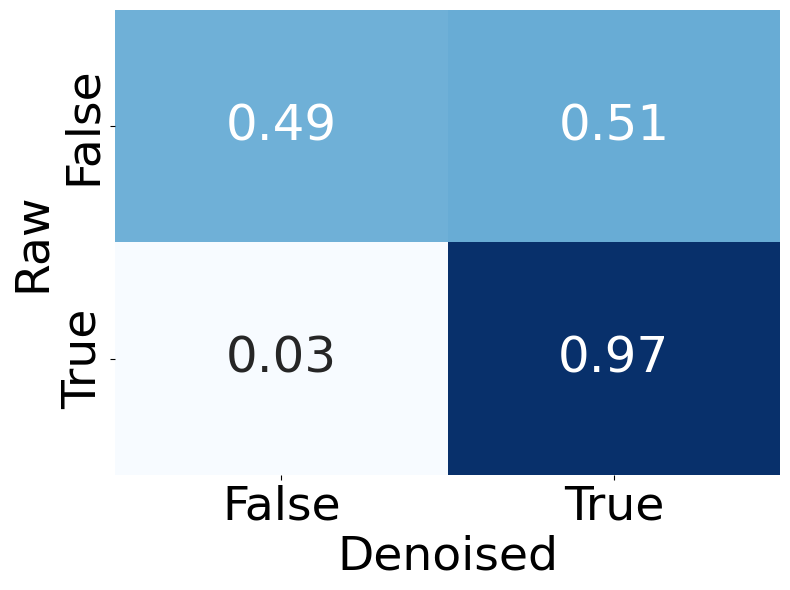

         True  Predicted
0        True       True
1       False       True
2       False       True
3       False       True
4       False       True
...       ...        ...
328159  False       True
328160  False      False
328161  False       True
328162  False       True
328163  False       True

[328164 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.3125615593948992, 'Accuracy': 0.30027973817969067}


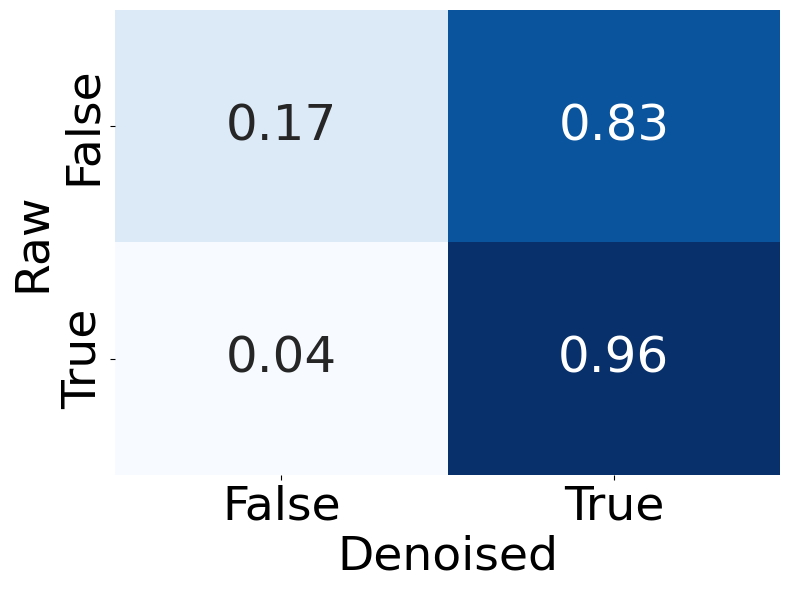

/tmp/ipykernel_1204373/3160381379.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Method', y='Correlation', data=df, inner=None, palette=palette)


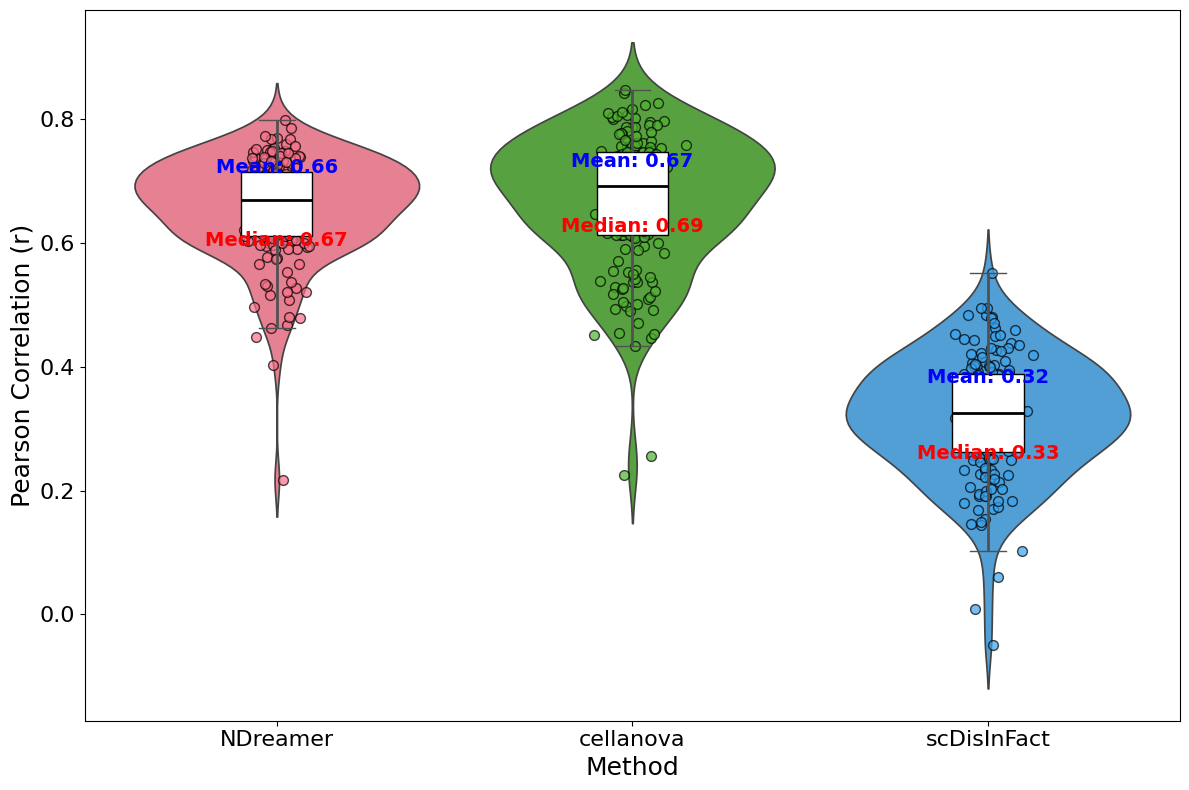

In [10]:
df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/reproducible/evaluate/ASD101_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/reproducible/evaluate/ASD101_denoised_DE.csv")
results_ndreamer=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/cellanova/ASD1_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/cellanova/ASD1_denoised_DE.csv")
results_cellanova=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/scd/ASD1_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/scd/ASD1_denoised_DE.csv")
results_scd=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

paired_comparison_box_violin_plot([results_ndreamer,results_cellanova,results_scd], ["NDreamer","cellanova", "scDisInFact"])

# T1D dataset

         True  Predicted
0       False       True
1       False       True
2       False       True
3       False      False
4        True       True
...       ...        ...
334162  False      False
334163  False      False
334164  False      False
334165  False      False
334166  False      False

[334167 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.5452021817629773, 'Accuracy': 0.8744908982634432}


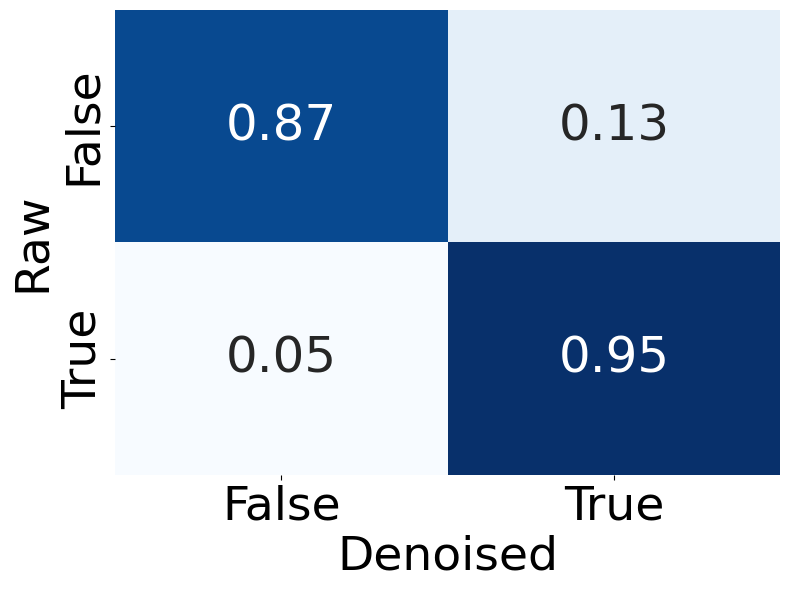

In [11]:
df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control/evaluate/t1d_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control/evaluate/t1d_denoised_DE.csv")
results_ndreamer=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

         True  Predicted
0       False       True
1       False       True
2       False      False
3       False      False
4       False       True
...       ...        ...
501162  False      False
501163  False      False
501164  False      False
501165  False       True
501166  False      False

[501167 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.4391766666750718, 'Accuracy': 0.5562098063120676}


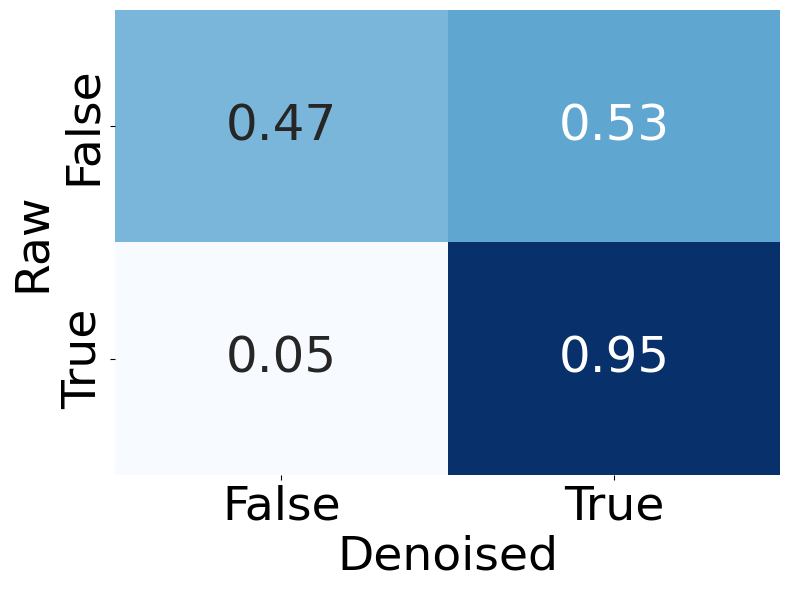

In [12]:
df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/cellanova/t1d_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/cellanova/t1d_denoised_DE.csv")
results_cellanova=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

         True  Predicted
0       False       True
1       False       True
2       False       True
3       False       True
4       False       True
...       ...        ...
501162  False       True
501163  False       True
501164  False       True
501165  False       True
501166  False      False

[501167 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.3293425218848948, 'Accuracy': 0.28152492083477165}


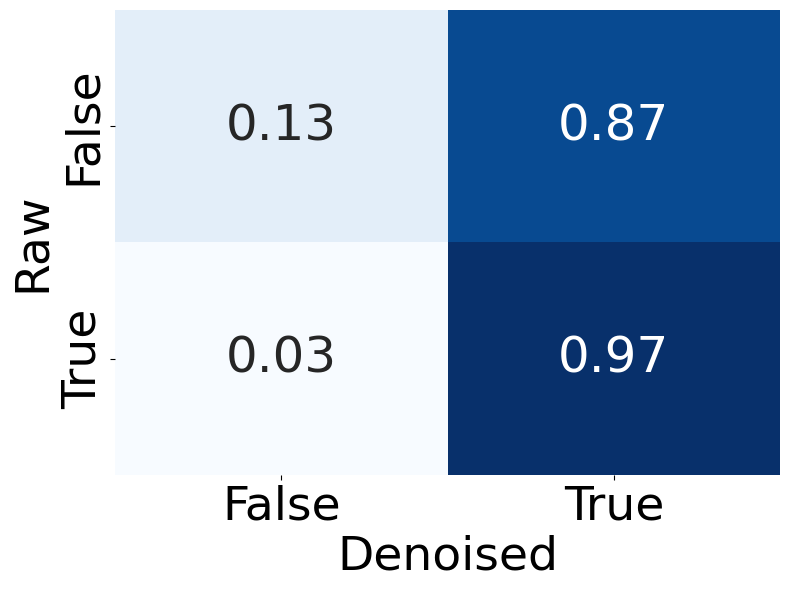

In [13]:
df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/scd/t1d_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/scd/t1d_denoised_DE.csv")
results_scd=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

/tmp/ipykernel_1204373/3160381379.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Method', y='Correlation', data=df, inner=None, palette=palette)


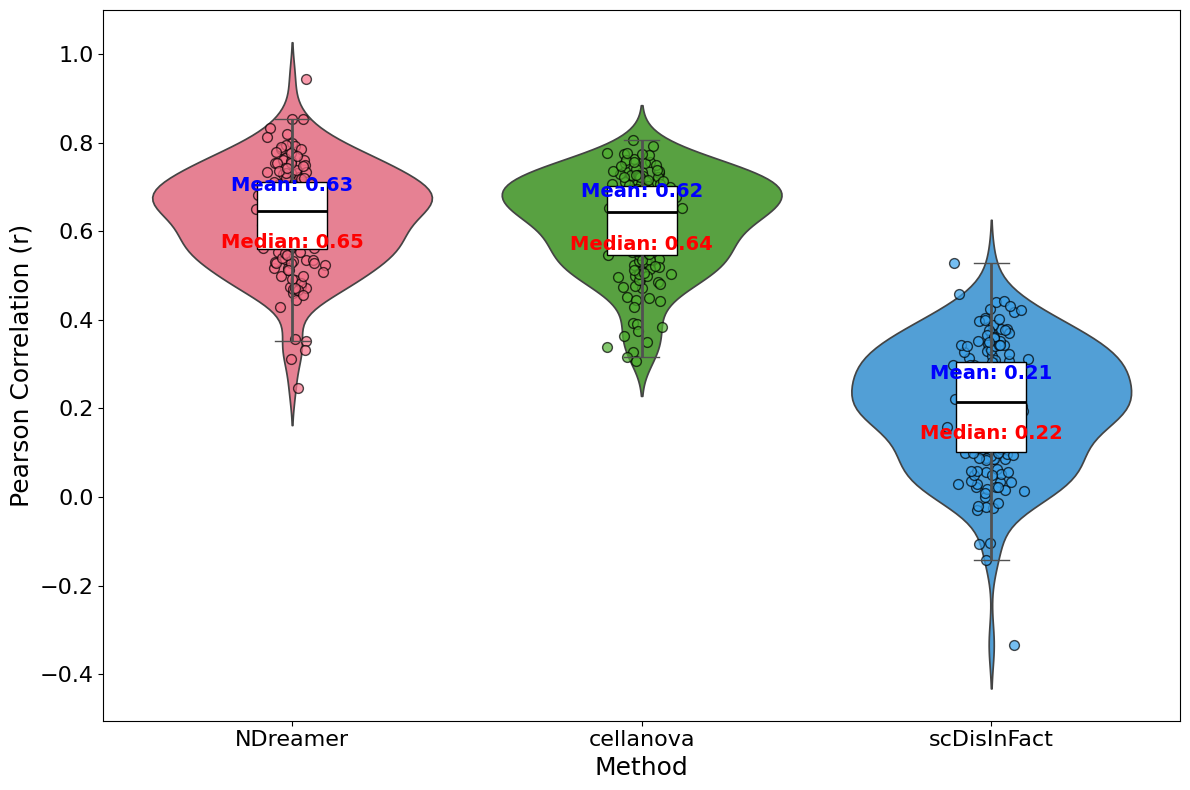

In [14]:
paired_comparison_box_violin_plot([results_ndreamer,results_cellanova,results_scd], ["NDreamer","cellanova", "scDisInFact"])

# Kidney dataset

          True  Predicted
0        False       True
1        False       True
2        False      False
3        False      False
4        False       True
...        ...        ...
1406698  False      False
1406699  False      False
1406700  False      False
1406701  False       True
1406702  False      False

[1406703 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.27264130299862177, 'Accuracy': 0.5959338964941426}


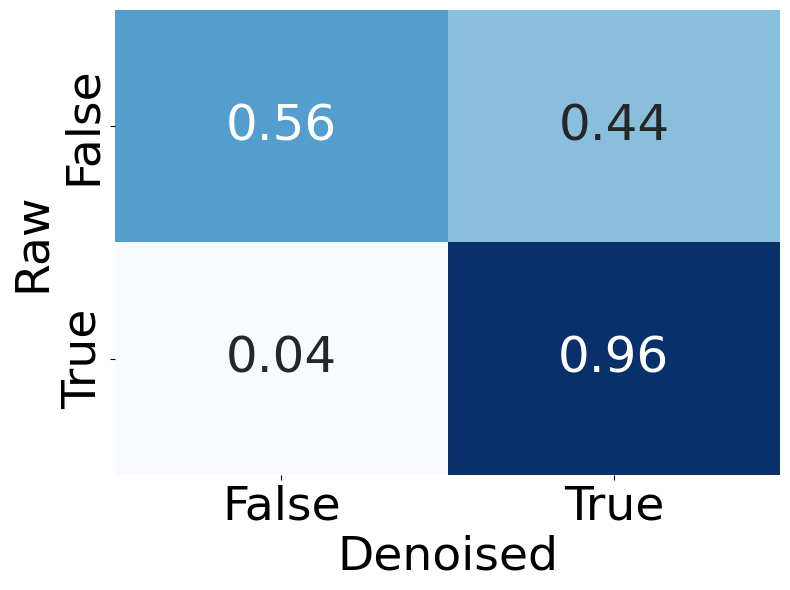

In [15]:
df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control/evaluate/kidney_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control/evaluate/kidney_denoised_DE.csv")
results_ndreamer=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

          True  Predicted
0        False       True
1        False       True
2        False       True
3        False       True
4        False       True
...        ...        ...
2109698  False      False
2109699  False      False
2109700  False      False
2109701  False      False
2109702  False      False

[2109703 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.33575457868405634, 'Accuracy': 0.4276184846871811}


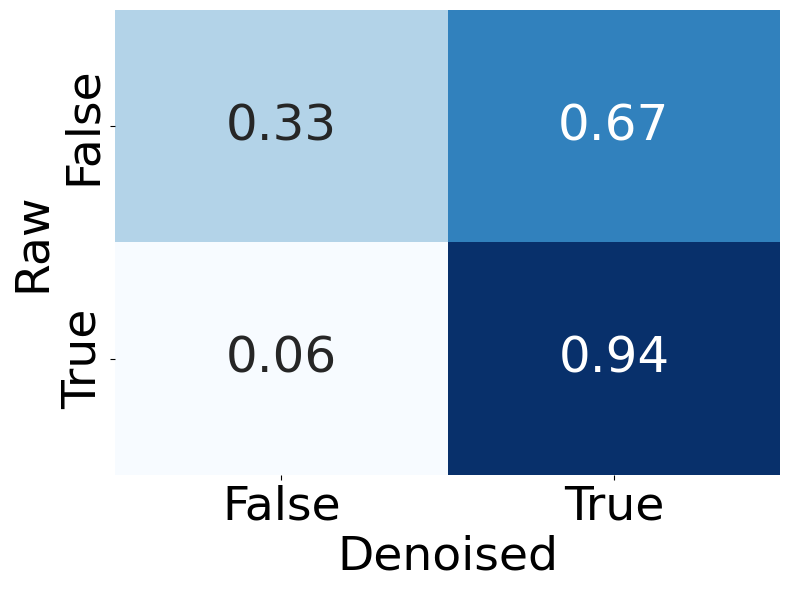

In [16]:
df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/cellanova/kidney_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/cellanova/kidney_denoised_DE.csv")
results_cellanova=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

/tmp/ipykernel_1204373/156221127.py:55: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(logit1, logit2)


          True  Predicted
0         True       True
1         True       True
2        False       True
3        False       True
4        False       True
...        ...        ...
2109698  False       True
2109699  False       True
2109700  False       True
2109701  False       True
2109702  False       True

[2109703 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.27954233243470966, 'Accuracy': 0.2850510237696965}


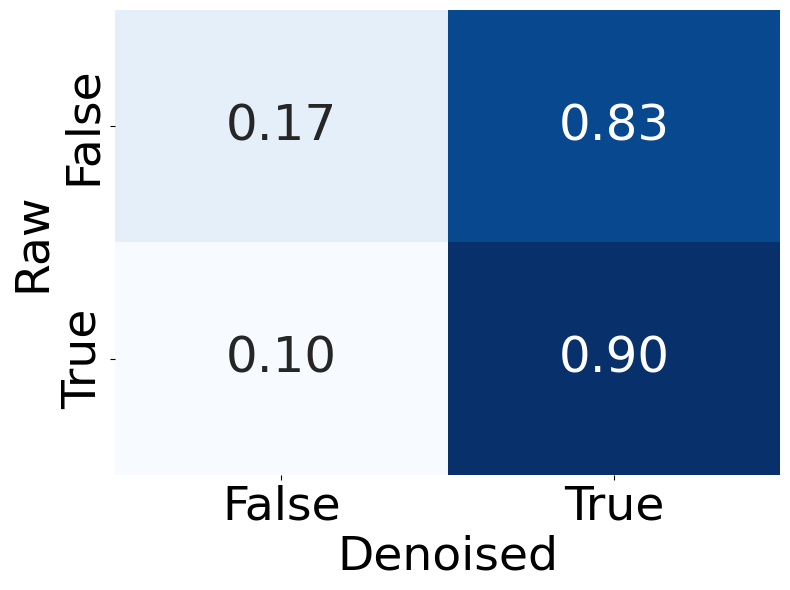

In [17]:
df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/scd/kidney_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/scd/kidney_denoised_DE.csv")
results_scd=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

/tmp/ipykernel_1204373/3160381379.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Method', y='Correlation', data=df, inner=None, palette=palette)


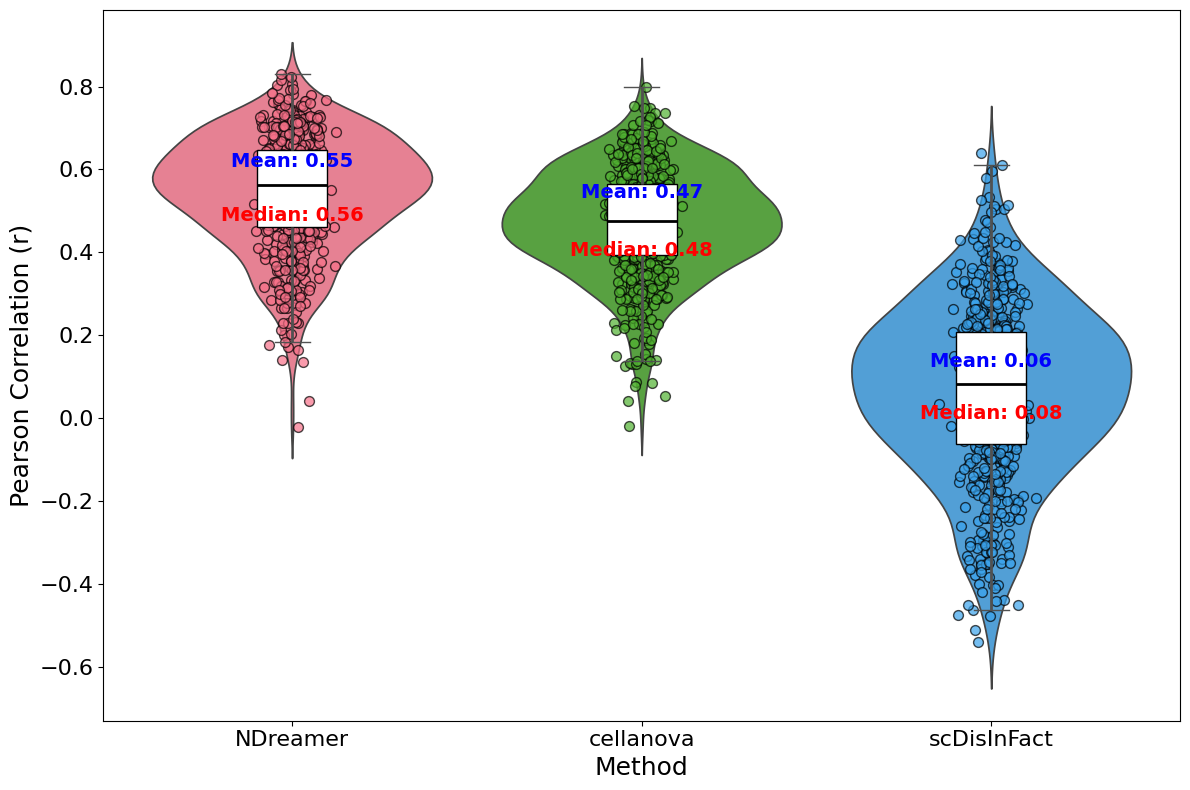

In [18]:
paired_comparison_box_violin_plot([results_ndreamer,results_cellanova,results_scd], ["NDreamer","cellanova", "scDisInFact"])

# Mouse dataset

        True  Predicted
0      False       True
1      False      False
2      False      False
3      False      False
4      False      False
...      ...        ...
40015  False       True
40016  False      False
40017   True       True
40018   True       True
40019   True       True

[40020 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.7989094669549686, 'Accuracy': 0.8931034482758621}


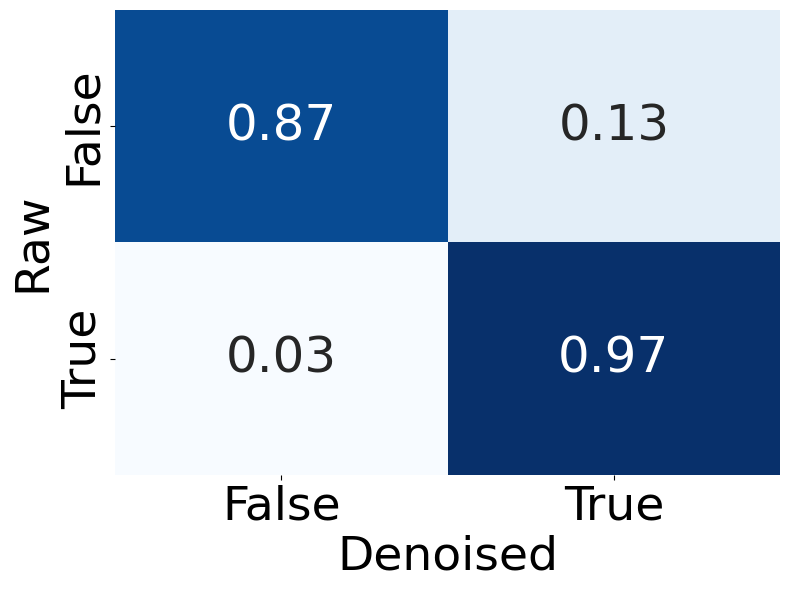

In [8]:
df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control/evaluate/mouse_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control/evaluate/mouse_denoised_DE.csv")
results_ndreamer=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

        True  Predicted
0      False       True
1      False       True
2       True       True
3      False       True
4      False       True
...      ...        ...
60015  False      False
60016  False      False
60017  False      False
60018  False      False
60019  False      False

[60020 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.7363384995997962, 'Accuracy': 0.7585138287237587}


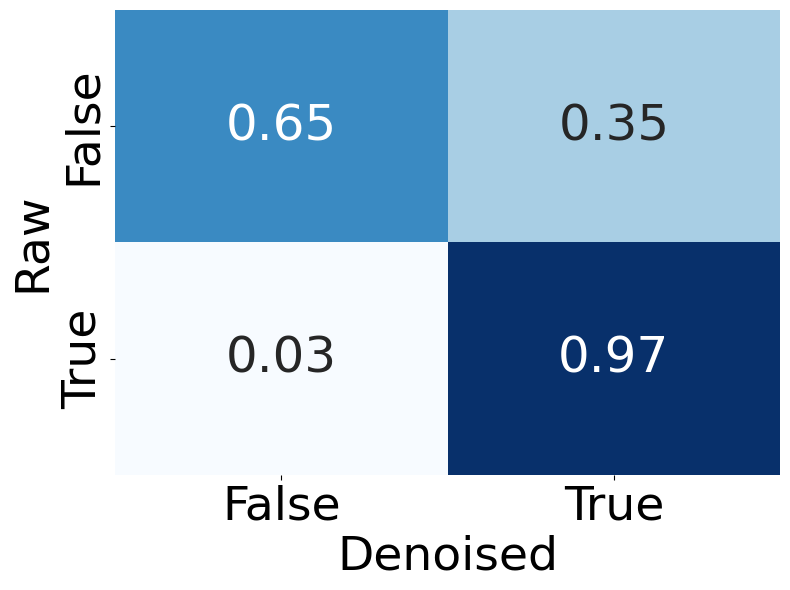

In [9]:
df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/cellanova/mouse_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/cellanova/mouse_denoised_DE.csv")
results_cellanova=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

        True  Predicted
0      False       True
1       True       True
2       True       True
3      False       True
4      False       True
...      ...        ...
60015   True       True
60016   True       True
60017   True       True
60018   True       True
60019   True       True

[60020 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.7319250328959066, 'Accuracy': 0.7488170609796735}


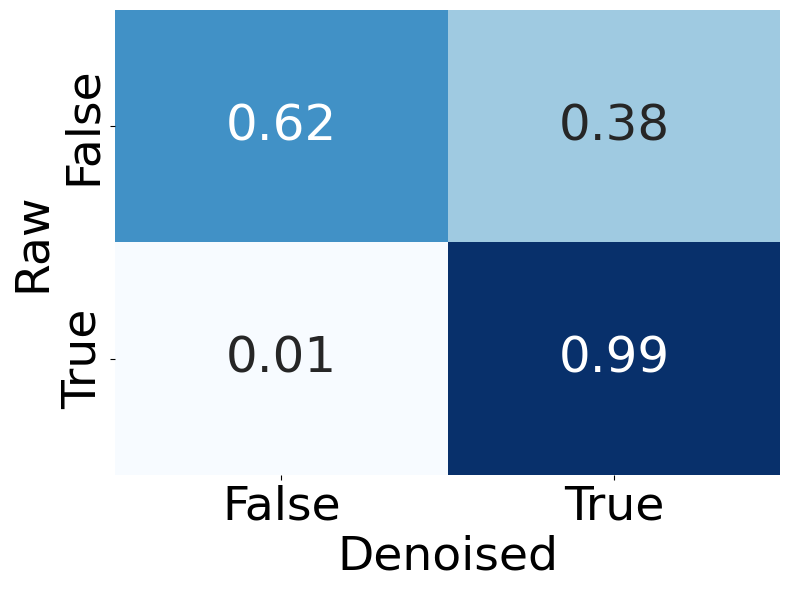

In [10]:
df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/scd/mouse_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/scd/mouse_denoised_DE.csv")
results_scd=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

/tmp/ipykernel_2727780/3160381379.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Method', y='Correlation', data=df, inner=None, palette=palette)


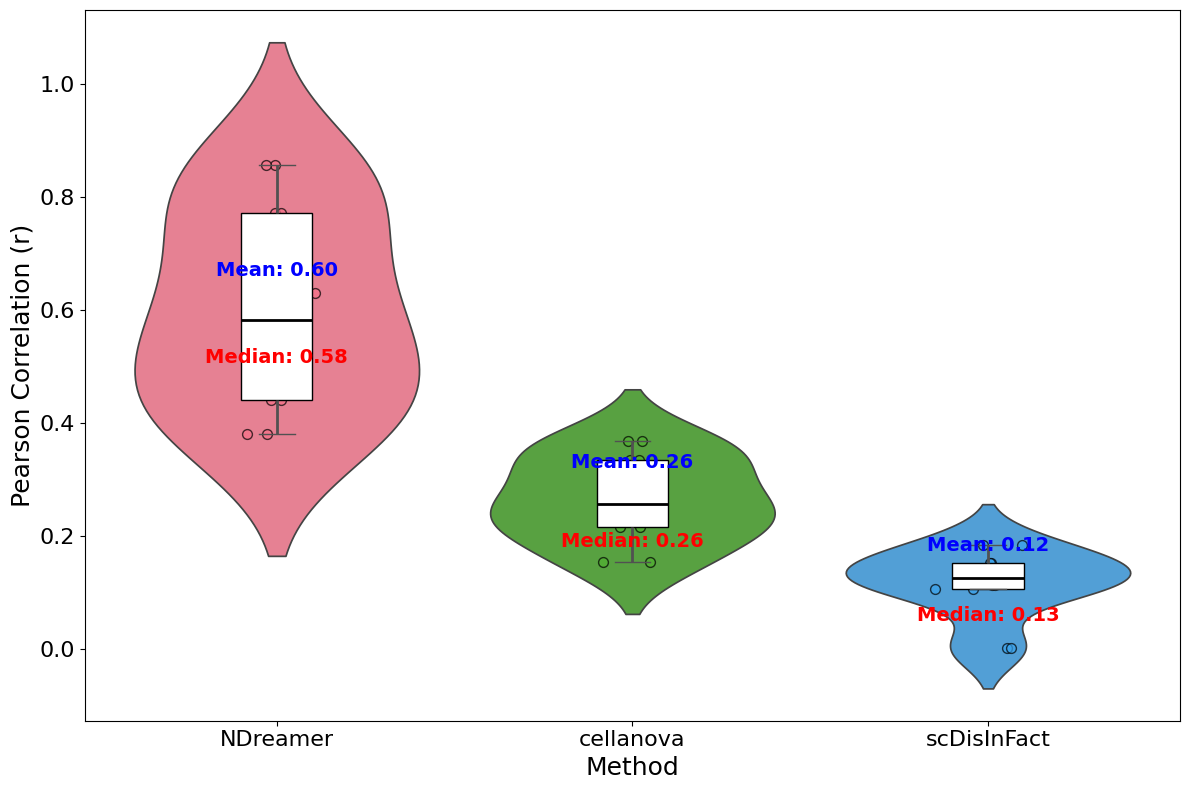

In [11]:
paired_comparison_box_violin_plot([results_ndreamer,results_cellanova,results_scd], ["NDreamer","cellanova", "scDisInFact"])

# SEA-AD dataset

          True  Predicted
0        False      False
1        False       True
2         True       True
3         True       True
4        False       True
...        ...        ...
3719854  False      False
3719855  False      False
3719856  False      False
3719857  False      False
3719858  False      False

[3719859 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.5849451901112419, 'Accuracy': 0.5707460954837267}


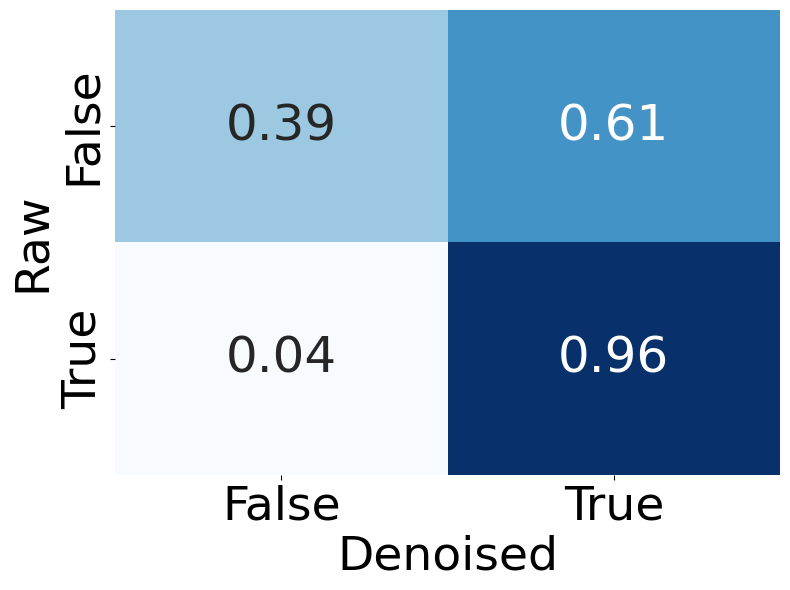

          True  Predicted
0        False       True
1        False       True
2        False       True
3        False      False
4        False       True
...        ...        ...
3719854  False      False
3719855  False      False
3719856  False      False
3719857  False      False
3719858  False      False

[3719859 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.594600361141363, 'Accuracy': 0.5985218794583343}


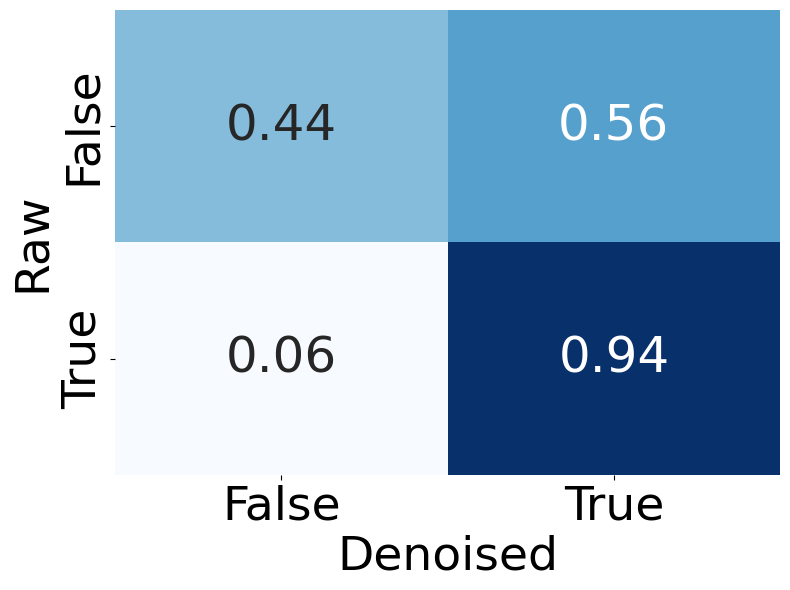

          True  Predicted
0        False       True
1        False       True
2         True       True
3         True       True
4        False       True
...        ...        ...
3719854  False       True
3719855  False       True
3719856  False       True
3719857  False       True
3719858  False      False

[3719859 rows x 2 columns]
Accuracy and F1 score {'F1 Score': 0.4873349761887422, 'Accuracy': 0.36607462809746283}


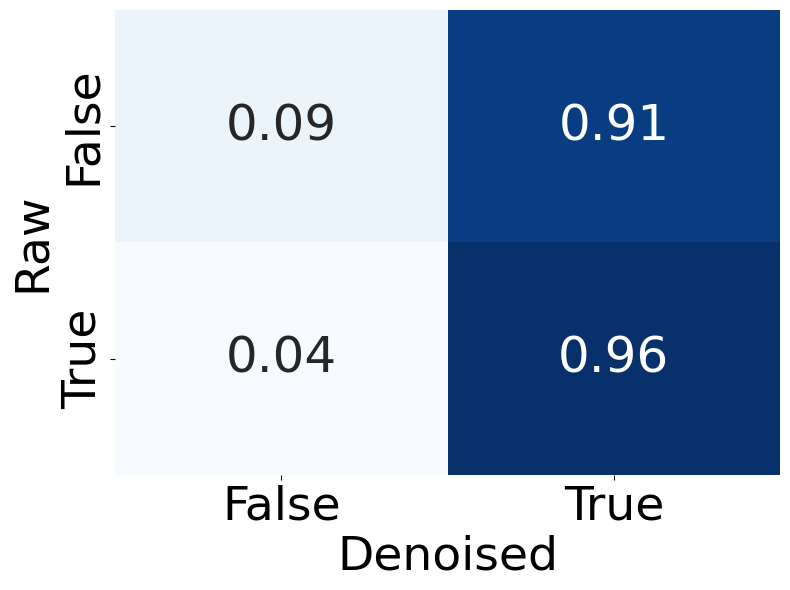

/tmp/ipykernel_1204373/3160381379.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Method', y='Correlation', data=df, inner=None, palette=palette)


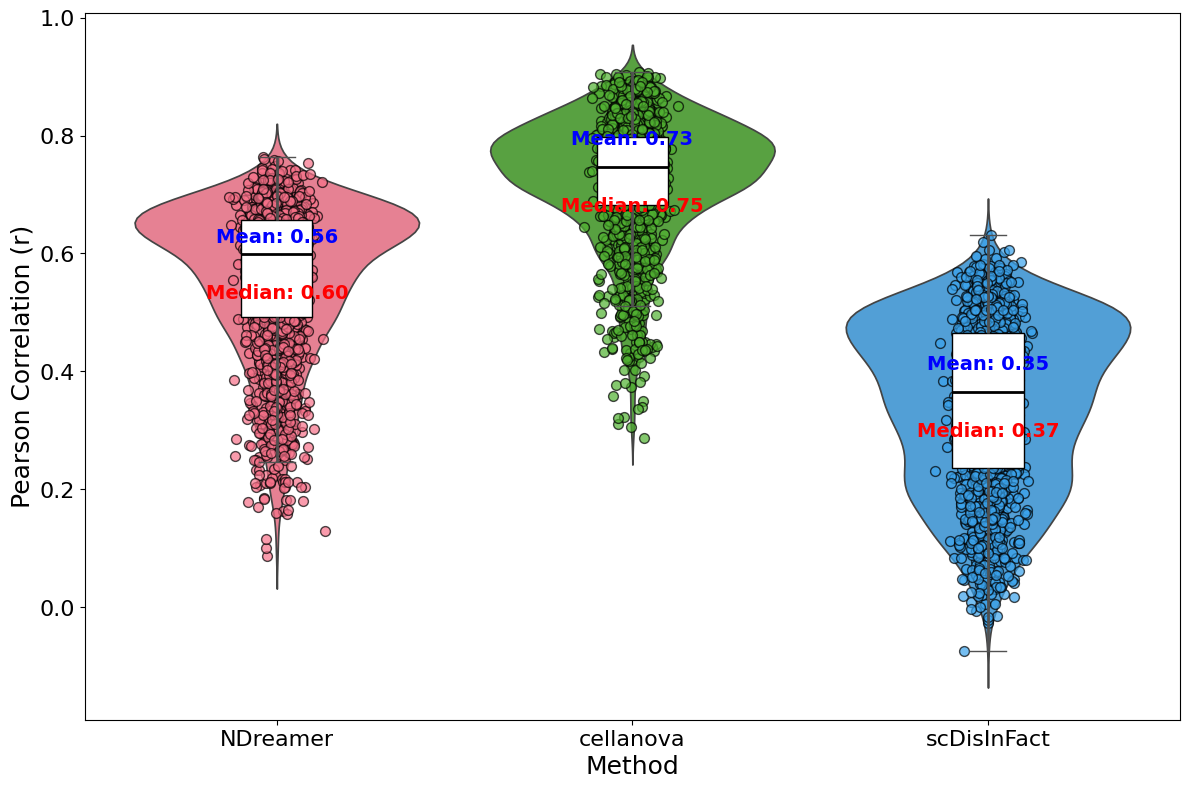

In [19]:
df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control/evaluate/AD_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control/evaluate/AD_denoised_DE.csv")
results_ndreamer=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/cellanova/AD_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/cellanova/AD_denoised_DE.csv")
results_cellanova=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

df1=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/scd/AD_real_DE.csv")
df2=pd.read_csv("/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/scd/AD_denoised_DE.csv")
results_scd=calculate_pearson_r(df1,df2)
mark_pvalues_and_plot_confusion(df1,df2)

paired_comparison_box_violin_plot([results_ndreamer,results_cellanova,results_scd], ["NDreamer","cellanova", "scDisInFact"])